In [1]:
from urllib.request import urlopen
import json 
import pandas as pd

url = "https://raw.githubusercontent.com/suneman/socialdata2022/main/files/sfpd.geojson"

with urlopen(url) as response:
    data = json.load(response)


df_pd = pd.read_csv("Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")

In [2]:
df = pd.DataFrame(columns=["x","y"])


# Iterate over features and extract flattened coordinates
for feature in data['features']:
    coordinates = [coord for sublist in feature['geometry']['coordinates'] for coord in sublist]
    x_values = [coord[0] for coord in coordinates]
    y_values = [coord[1] for coord in coordinates]
    district_df = pd.DataFrame({'x': x_values, 'y': y_values})
    df = pd.concat([df, district_df], ignore_index=True)

print(df.head())


            x          y
0 -122.405321  37.806868
1 -122.404401  37.808854
2 -122.404387  37.808865
3 -122.404367  37.808873
4 -122.404344   37.80887


In [3]:
print(len(df))

df = df[df.apply(lambda x: isinstance(x['x'], float) or isinstance(x['y'], float), axis=1)]
print(len(df))
df = df[(df.y < 50) & (df.x<-122)]
print(len(df))



6385
6383
6383


In [4]:
df_pd = df_pd[(df_pd.Y < 50) & (df_pd.X<-122)]


In [5]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


In [6]:
lat_min = df_pd.Y.min()
lat_max = df_pd.Y.max()
lon_min = df_pd.X.min()
lon_max = df_pd.X.max()



In [7]:
print(f"Estimated bin amount along the western border of San Fransisco: {haversine(lon_min, lat_min, lon_min, lat_max)*10}") 
print(f"Estimated bin amount along the eastern border of San Fransisco: {haversine(lon_max, lat_min, lon_max, lat_max)*10}")


Estimated bin amount along the western border of San Fransisco: 125.36317921721148
Estimated bin amount along the eastern border of San Fransisco: 125.36317921721148


In [8]:
print(f"Estimated bin amount along the northern border of San Fransisco: {haversine(lon_min, lat_max, lon_max, lat_max)*10}")
print(f"Estimated bin amount along the southern border of San Fransisco: {haversine(lon_min, lat_min, lon_max, lat_min)*10}")


Estimated bin amount along the northern border of San Fransisco: 130.78123566673807
Estimated bin amount along the southern border of San Fransisco: 130.9807444161078


In [9]:
import numpy as np 

count, lon, lat = np.histogram2d(df_pd.Y,df_pd.X, bins=[130,125])

In [23]:
print(count)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 2.]]


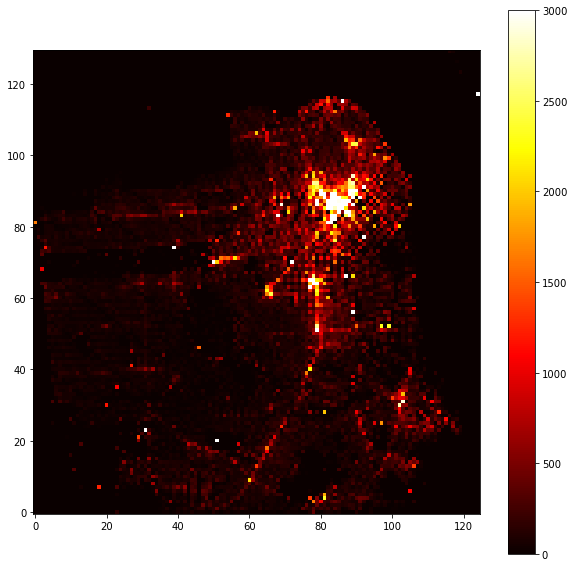

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(count,cmap='hot',vmax=3000,origin='lower')
plt.colorbar()

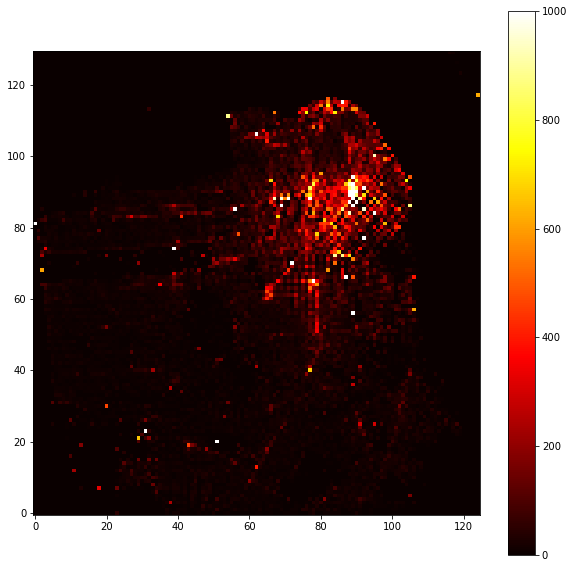

In [30]:
theft_data = df_pd[df_pd["Category"]=="LARCENY/THEFT"]
count_theft, lon_theft, lat_theft = np.histogram2d(theft_data.Y,theft_data.X, bins=[130,125])
plt.figure(figsize=(10,10))
plt.imshow(count_theft,cmap='hot',vmax=1000,origin='lower')
plt.colorbar()

In [93]:
k = []
max_ = int(count_theft.max())
k, _ = np.histogram(count_theft, bins=np.arange(count_theft.max()))
K = [i for i in range(1,max_)]
print(len(k),len(k))

17141 17141


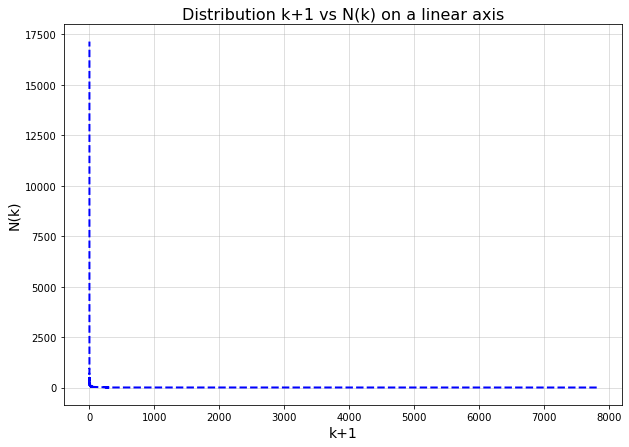

In [94]:
fig = plt.figure(figsize=(10,7))

plt.plot(k,K,color="blue",linestyle="--",linewidth=2)
plt.xlabel("k+1",fontsize=14) 
plt.ylabel("N(k)",fontsize=14)
plt.title('Distribution k+1 vs N(k) on a linear axis', fontsize=16)
plt.grid(alpha=0.5)

plt.show()

<ipython-input-117-0e3b863b4a8f>:1: RuntimeWarning: divide by zero encountered in log
  k_log = np.log(k)


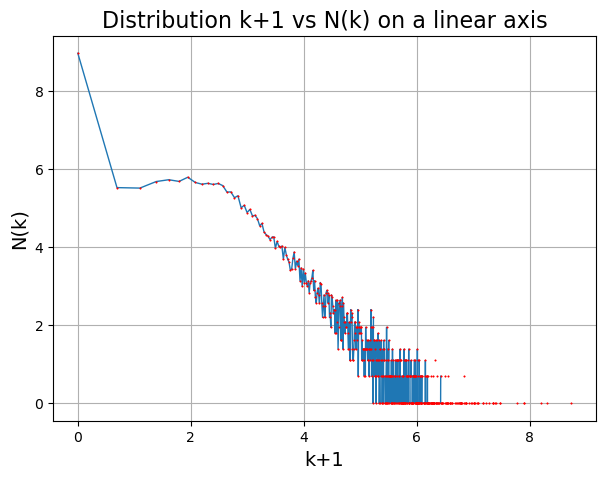

In [117]:
k_log = np.log(k)
K_log = np.log(K)

fig = plt.figure(figsize=(7,5))
plt.plot(K_log, k_log, '-', linewidth=1, marker='s', markersize=0.5, markerfacecolor='white', markeredgecolor='red')
plt.xlabel("k+1",fontsize=14) 
plt.ylabel("N(k)",fontsize=14)
plt.title('Distribution k+1 vs N(k) on a linear axis', fontsize=16)
plt.grid(True)
plt.box(True)

plt.show()

In [11]:

steps = 0.0018
to_bin = lambda x: np.floor(x/steps)*steps
df_pd["latBin"] = to_bin(df_pd.Y)
df_pd["lonBin"] = to_bin(df_pd.X)
df_pdd = df_pd[df_pd["Category"]=="LARCENY/THEFT"]
groups = df_pdd.groupby(["lonBin","latBin","Category"]).size()

## Part 2 Linear regression

In [20]:
import datetime

##Way too much code i will need to trim down later
focuscrimes = ['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT']

#Re-formating the time column as a float variable
func1 = lambda x: float(x.split(":")[0])+float(x.split(":")[1])*(1/60)
df_pd["Time_float"] = df_pd["Time"].apply(func1)
dic = {"Monday": 0,"Tuesday":24,"Wednesday":48,"Thursday": 72,"Friday": 96,"Saturday":120,"Sunday":144}
#Transforming the hour of the day to hour of the week 
func = lambda x,y: dic[x]+y 
df_pd["HourOfTheWeek"] = df_pd.apply(lambda row: func(row["DayOfWeek"], row["Time_float"]), axis=1)
df_pd['HourOfTheWeek'] = np.round(df_pd['HourOfTheWeek']).astype(int)
df_crimehour = df_pd.groupby([ 'HourOfTheWeek','Category']).size().reset_index(name='count')
df_crimehour = df_crimehour[df_crimehour["Category"].isin(focuscrimes)][["Category","HourOfTheWeek","count"]]



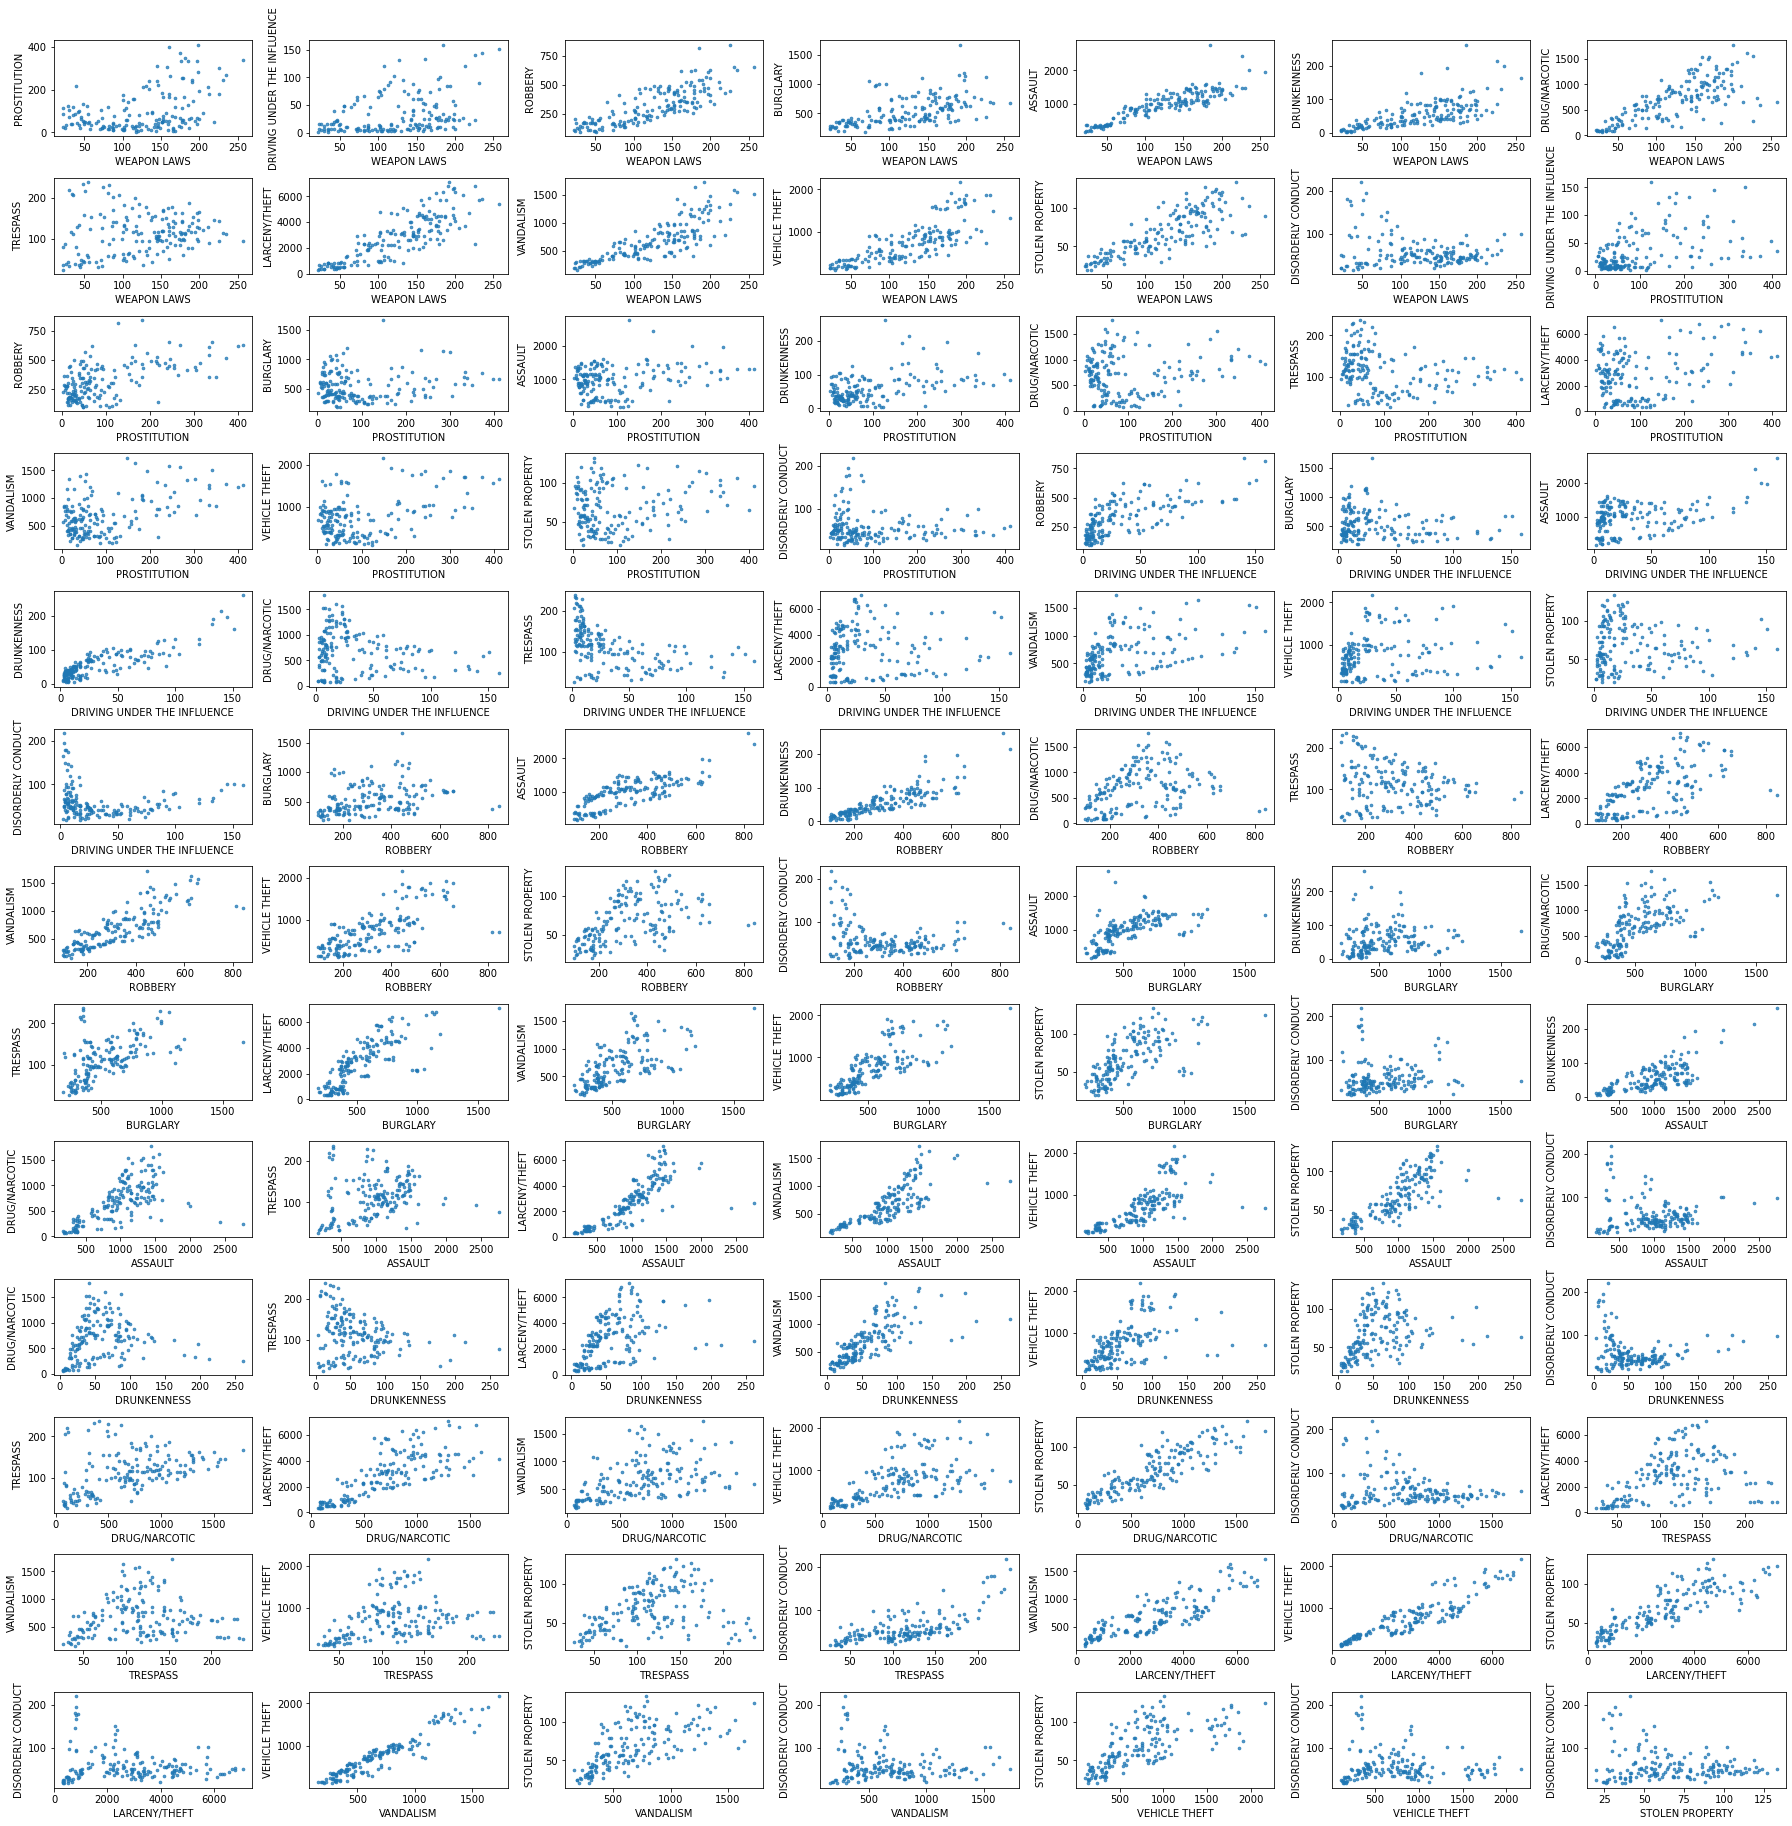

In [21]:


focuscrimes = ['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT']

n = 0
fig,ax = plt.subplots(13,7,figsize=(25,25))
ax = ax.flatten()
m = -1

for crime in focuscrimes:
    crime1 = df_crimehour[df_crimehour["Category"]==crime]
    m+=1
    for index in range(m+1,len(focuscrimes)):
        crime2 = df_crimehour[df_crimehour["Category"]== focuscrimes[index]]
        ax[n].scatter(crime1["count"],crime2["count"], s=7, alpha=0.75)
        ax[n].set_xlabel(crime,fontsize=10)
        ax[n].set_ylabel(focuscrimes[index], fontsize=10)
        ax[n].tick_params(labelsize=10)

        n+=1

plt.tight_layout()
plt.show()


In [163]:
## needs to be fixed
def coefficients(x, y):
    a = (np.sum(x*y)- len(x) * np.mean(x)*np.mean(y)) / np.sum(x**2)- len(x)*np.mean(x)**2
    b = np.mean(y) - np.mean(x) * a
    return a, b

    

In [159]:
from sklearn.linear_model import LinearRegression

def sklearn_coeff(x,y):

    x = np.array(x).reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    lr = LinearRegression()
   
    # fit the model to the data
    lr.fit(x,y)

    # retrieve the coefficients
    a = lr.coef_
    b = lr.intercept_
    return a,b



In [167]:
df_crimehour

,Category,HourOfTheWeek,count
1,ASSAULT,0,858
4,BURGLARY,0,432
5,DISORDERLY CONDUCT,0,41
6,DRIVING UNDER THE INFLUENCE,0,47
7,DRUG/NARCOTIC,0,342
...,...,...,...
5696,STOLEN PROPERTY,168,35
5699,TRESPASS,168,33
5700,VANDALISM,168,351
5701,VEHICLE THEFT,168,348


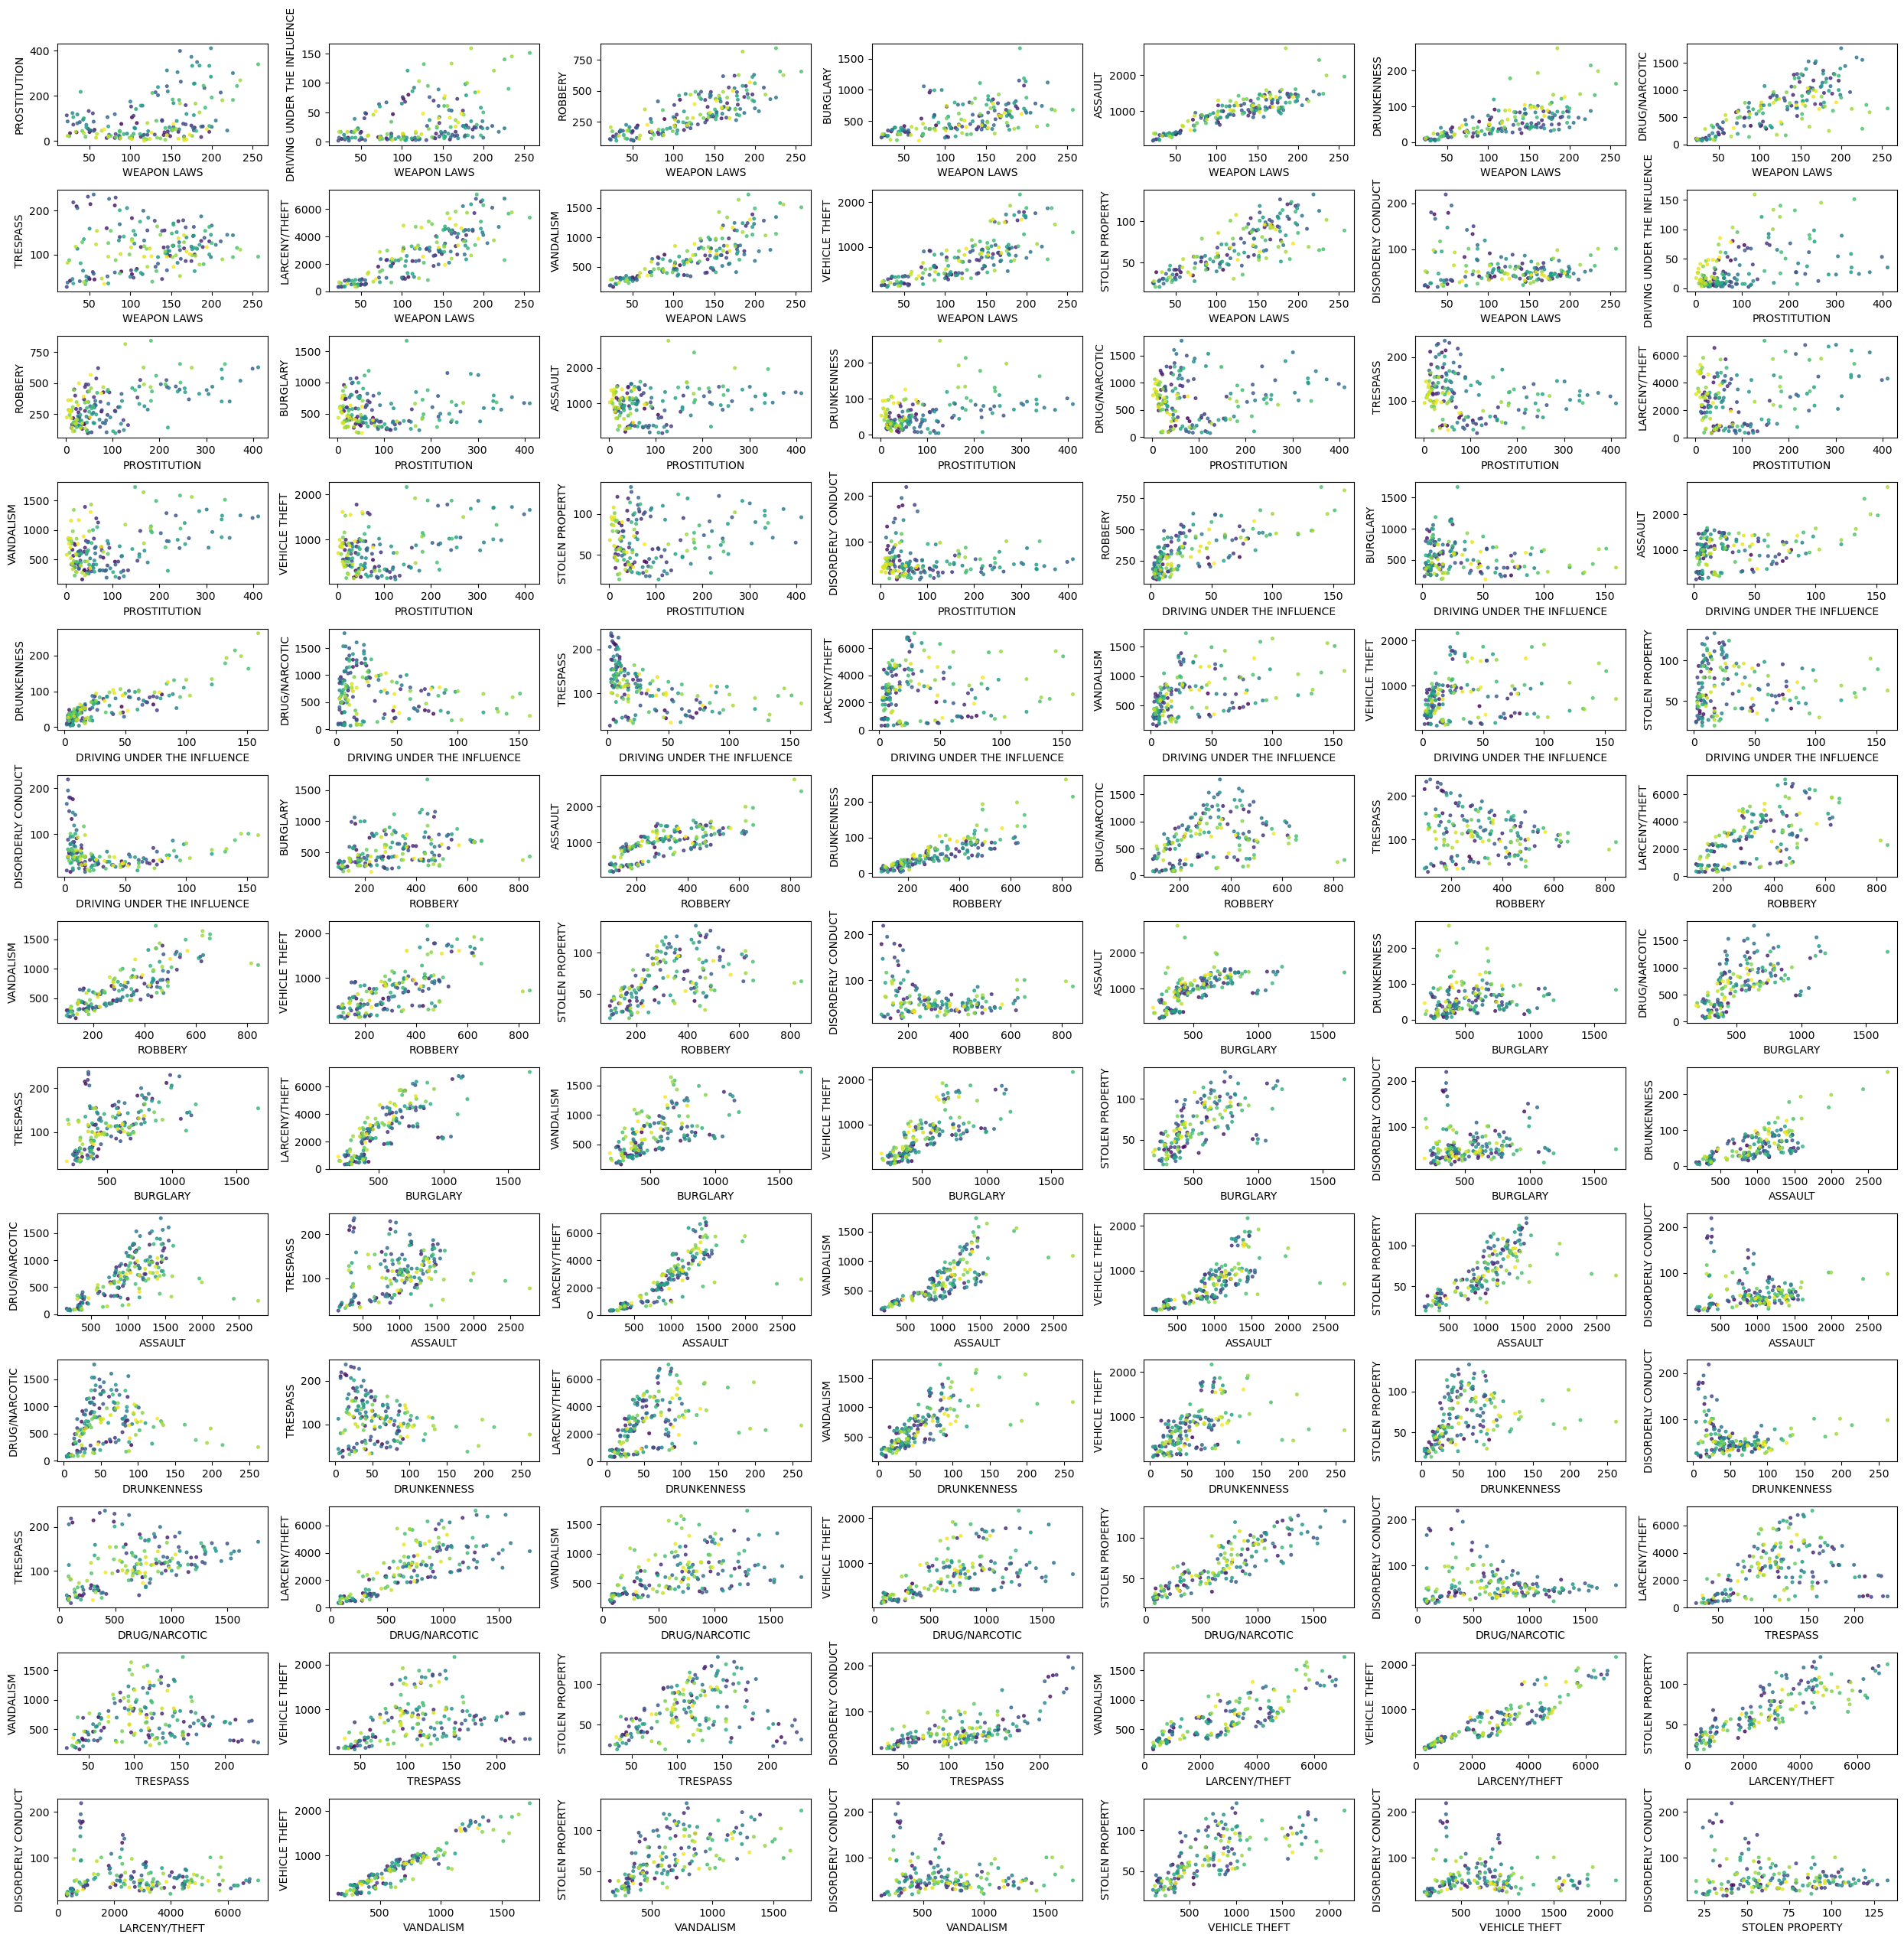

In [175]:
import matplotlib.collections as mcoll
n = 0
fig,ax = plt.subplots(13,7,figsize=(25,25))
ax = ax.flatten()
m = -1

for crime in focuscrimes:
    crime1 = df_crimehour[df_crimehour["Category"]==crime]
    m+=1
    for index in range(m+1,len(focuscrimes)):
        crime2 = df_crimehour[df_crimehour["Category"]== focuscrimes[index]]
        ax[n].scatter(crime1["count"],crime2["count"], s=7,c=crime1["HourOfTheWeek"], alpha=0.75,cmap=["Blues","Reds"])
        ax[n].set_xlabel(crime,fontsize=10)
        ax[n].set_ylabel(focuscrimes[index], fontsize=10)
        ax[n].tick_params(labelsize=10)

        n+=1
plt.tight_layout()
plt.show()